<a href="https://colab.research.google.com/github/Nuette/SceneDetection/blob/main/RuleBasedSceneDetection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy coreferee transformers
!python -m spacy download en_core_web_lg
!python -m coreferee install en


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.6/182.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.0.5
    Uninstalling smart-open-7.0.5:
      Successfully uninstalled smart-open-7.0.5
  Attempting uninstall: pydantic
    Found existin

In [2]:
import spacy
import coreferee
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe('coreferee')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
file_path = 'The_adventures_of_the_Italian_nobleman.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()


Functions for extracting characters, places, time, dialogue detection, descriptive passages, and semantic similarity using BERT.


In [5]:
# Function to identify characters
def get_character_mentions(doc):
    character_mentions = {}
    for chain in doc._.coref_chains.chains:
        main_mention = chain[0]
        main_mention_span = doc[main_mention.token_indexes[0]:main_mention.token_indexes[-1] + 1]

        if main_mention_span.root.pos_ == "PROPN":
            mentions = []
            for mention in chain:
                mention_span = doc[mention.token_indexes[0]:mention.token_indexes[-1] + 1]
                mentions.append(mention_span.text)
            character_mentions[main_mention_span.text] = mentions
    return character_mentions

# Function to identify places
def get_place_mentions(doc):
    places = set(ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"])
    return places

# Function to identify time mentions
def get_time_mentions(doc):
    times = set(ent.text for ent in doc.ents if ent.label_ in ["DATE", "TIME"])
    return times

# Function to detect dialogue
def is_dialogue(sentence):
    return sentence.startswith('"') or sentence.endswith('"')

# Function to detect descriptive passages
def is_heavily_descriptive(doc):
    adjectives = [token for token in doc if token.pos_ == "ADJ"]
    if len(adjectives) > 10:  # Adjust threshold based on the text
        return True
    return False

# Function to compute BERT-based semantic similarity between two windows
def compute_bert_similarity(window_text1, window_text2):
    inputs1 = tokenizer(window_text1, return_tensors='pt', truncation=True, padding=True)
    inputs2 = tokenizer(window_text2, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        outputs1 = bert_model(**inputs1).last_hidden_state.mean(dim=1).numpy()
        outputs2 = bert_model(**inputs2).last_hidden_state.mean(dim=1).numpy()

    similarity = cosine_similarity(outputs1, outputs2)[0][0]
    return similarity

# Function to replace coreferent mentions using coreferee
def replace_coreferences(doc):
    coref_resolved_text = []
    for token in doc:
        if token._.coref_chains:
            for chain in doc._.coref_chains.chains:
                if token.i in chain:
                    main_entity = doc[chain[0].token_indexes[0]:chain[0].token_indexes[-1] + 1]
                    coref_resolved_text.append(main_entity.text)
                    break
        else:
            coref_resolved_text.append(token.text)
    return " ".join(coref_resolved_text)


Function to save segmentation output in the same format as the human-annotated data

In [6]:
def save_segments_to_json(segments, file_path):
    formatted_segments = []
    current_start = 0  # Initialize the start position in terms of characters

    for segment in segments:
        text_length = len(segment['text'])

        start = current_start
        end = start + text_length - 1

        formatted_segments.append({
            "start": start,
            "end": end,
            "scene_type": segment['type'],  # "scene" or "non-scene"
            "text": segment['text']
        })

        current_start = end

    with open(file_path, 'w', encoding='utf-8') as json_file:
        json.dump(formatted_segments, json_file, ensure_ascii=False, indent=4)

Apply the spaCy pipeline, replace coreferences using token-level replacement, and segment text using a sliding window. Introduce place memory, dialogue detection, descriptive passage detection, and semantic similarity checks.


Define parameter ranges to test

In [7]:
window_sizes = [1,2]
character_change_thresholds = [2,3]
similarity_thresholds = [0.85, 0.9]
place_memory_window_sizes = [1, 2]

results_list = []
rule_based_files = []

In [8]:
total_experiments = len(window_sizes) * len(character_change_thresholds) * len(similarity_thresholds) * len(place_memory_window_sizes)
experiment_counter = 1

Function to perform segmentation with varying parameters

In [9]:
def run_segmentation(window_size, character_change_threshold, similarity_threshold, place_memory_window_size):
    previous_characters = set()
    previous_time = set()
    previous_place = set()
    place_memory = set()
    segments = []
    current_segment = []
    current_type = 'scene'
    previous_window_text = None

    current_start = 0

    sentences = [sent.text.strip() for sent in nlp(text).sents]
    i = 0
    while i < len(sentences):
        window = sentences[i:i + window_size]
        window_text = " ".join(window)
        window_doc = nlp(window_text)

        resolved_window_text = replace_coreferences(window_doc)
        window_doc_resolved = nlp(resolved_window_text)

        window_characters = {ent.text for ent in window_doc_resolved.ents if ent.label_ == "PERSON"}
        window_times = get_time_mentions(window_doc_resolved)
        window_places = get_place_mentions(window_doc_resolved)

        summary_detected = is_heavily_descriptive(window_doc_resolved)
        dialogue_detected = any(is_dialogue(sent) for sent in window)

        place_memory.update(window_places)
        if len(place_memory) > place_memory_window_size:
            place_memory = set(list(place_memory)[-place_memory_window_size:])

        if previous_window_text:
            similarity_score = compute_bert_similarity(previous_window_text, resolved_window_text)
        else:
            similarity_score = 1.0

        character_change_count = len(window_characters.symmetric_difference(previous_characters))

        if (character_change_count > character_change_threshold or
            not window_places.issubset(place_memory) or
            window_times != previous_time or
            summary_detected or
            similarity_score < similarity_threshold):

            if current_segment:
                segment_text = " ".join(current_segment)
                segment_length = len(segment_text)
                segments.append({
                    'text': segment_text,
                    'type': current_type,
                    'start': current_start,
                    'end': current_start + segment_length - 1
                })
                current_segment = []
                current_start += segment_length + 1

            current_type = 'non-scene' if summary_detected else 'scene'
            place_memory.clear()

        current_segment.append(resolved_window_text)
        previous_characters = window_characters
        previous_time = window_times
        previous_place = window_places
        previous_window_text = resolved_window_text

        i += window_size

    if current_segment:
        segment_text = " ".join(current_segment)
        segment_length = len(segment_text)
        segments.append({
            'text': segment_text,
            'type': current_type,
            'start': current_start,
            'end': current_start + segment_length - 1
        })

    return segments


Loop through parameter combinations and save results

In [10]:
for window_size in window_sizes:
    for character_change_threshold in character_change_thresholds:
        for similarity_threshold in similarity_thresholds:
            for place_memory_window_size in place_memory_window_sizes:
                print(f"Running Experiment {experiment_counter}/{total_experiments} with parameters:")
                print(f" - Window Size: {window_size}")
                print(f" - Character Change Threshold: {character_change_threshold}")
                print(f" - Similarity Threshold: {similarity_threshold}")
                print(f" - Place Memory Window Size: {place_memory_window_size}")

                segments = run_segmentation(window_size, character_change_threshold, similarity_threshold, place_memory_window_size)

                for segment in segments[:2]:
                    if 'start' not in segment or 'end' not in segment or 'text' not in segment:
                        print(f"Warning: Segment is missing necessary keys. Current structure: {segment}")
                    else:
                        print(f"Segment structure is valid: Start: {segment['start']}, End: {segment['end']}")

                output_file_path = f'rule_based_scene_info_ws{window_size}_ct{character_change_threshold}_st{similarity_threshold}_pm{place_memory_window_size}.json'

                save_segments_to_json(segments, output_file_path)

                print(f"Segmentation saved to {output_file_path}")

                rule_based_files.append({
                    'file_name': output_file_path,
                    'segments': segments
                })

                print(f"Segmentation for {output_file_path} stored in memory.")

                experiment_counter += 1


Running Experiment 1/16 with parameters:
 - Window Size: 1
 - Character Change Threshold: 2
 - Similarity Threshold: 0.85
 - Place Memory Window Size: 1
Segment structure is valid: Start: 0, End: 70
Segment structure is valid: Start: 72, End: 184
Segmentation saved to rule_based_scene_info_ws1_ct2_st0.85_pm1.json
Segmentation for rule_based_scene_info_ws1_ct2_st0.85_pm1.json stored in memory.
Running Experiment 2/16 with parameters:
 - Window Size: 1
 - Character Change Threshold: 2
 - Similarity Threshold: 0.85
 - Place Memory Window Size: 2
Segment structure is valid: Start: 0, End: 70
Segment structure is valid: Start: 72, End: 184
Segmentation saved to rule_based_scene_info_ws1_ct2_st0.85_pm2.json
Segmentation for rule_based_scene_info_ws1_ct2_st0.85_pm2.json stored in memory.
Running Experiment 3/16 with parameters:
 - Window Size: 1
 - Character Change Threshold: 2
 - Similarity Threshold: 0.9
 - Place Memory Window Size: 1
Segment structure is valid: Start: 0, End: 70
Segment st

In [11]:
def validate_saved_segments():
    print("\nValidating stored segment files...\n")

    for rule_based_file in rule_based_files:
        file_name = rule_based_file['file_name']
        segments = rule_based_file['segments']

        print(f"Validating file: {file_name}")

        for i, segment in enumerate(segments[:2]):
            print(f"Segment {i + 1}:")
            if 'start' in segment and 'end' in segment and 'text' in segment:
                print(f" - Start: {segment['start']}, End: {segment['end']}, Text: {segment['text'][:50]}...")
            else:
                print(f"Segment {i + 1} is missing necessary keys. Current structure: {segment}")

        print("-" * 50)


validate_saved_segments()



Validating stored segment files...

Validating file: rule_based_scene_info_ws1_ct2_st0.85_pm1.json
Segment 1:
 - Start: 0, End: 70, Text: Poirot and I had many friends and acquaintances of...
Segment 2:
 - Start: 72, End: 184, Text: Amongst these was to be numbered Dr. Hawker , a ne...
--------------------------------------------------
Validating file: rule_based_scene_info_ws1_ct2_st0.85_pm2.json
Segment 1:
 - Start: 0, End: 70, Text: Poirot and I had many friends and acquaintances of...
Segment 2:
 - Start: 72, End: 184, Text: Amongst these was to be numbered Dr. Hawker , a ne...
--------------------------------------------------
Validating file: rule_based_scene_info_ws1_ct2_st0.9_pm1.json
Segment 1:
 - Start: 0, End: 70, Text: Poirot and I had many friends and acquaintances of...
Segment 2:
 - Start: 72, End: 184, Text: Amongst these was to be numbered Dr. Hawker , a ne...
--------------------------------------------------
Validating file: rule_based_scene_info_ws1_ct2_st0.9_pm2.j

#######################################################################################3

# Evaluation

We use a boundary edit distance + weighted F1 score to account for misalignments between the human segmented text and the rule-based segmented text.

Function to compute boundary error and weighted F1 score

In [12]:
def compute_boundary_error_and_confusion(predicted_boundaries, actual_boundaries, total_characters, tolerance=1):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_error = 0

    non_boundary_positions = set(range(total_characters)) - set(predicted_boundaries) - set(actual_boundaries)

    for pred in predicted_boundaries:
        matched = False
        for actual in actual_boundaries:
            if abs(pred - actual) <= tolerance:
                true_positives += 1
                total_error += abs(pred - actual)  # Penalize based on distance
                matched = True
                break
        if not matched:
            false_positives += 1  # Boundary predicted but no match found

    # Check for actual boundaries missed by predictions
    for actual in actual_boundaries:
        if not any(abs(pred - actual) <= tolerance for pred in predicted_boundaries):
            false_negatives += 1

    # True Negatives (positions where no boundary exists)
    true_negatives = len(non_boundary_positions)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    avg_boundary_error = total_error / true_positives if true_positives > 0 else float('inf')
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "true_negatives": true_negatives,
        "f1_score": f1_score,
        "avg_boundary_error": avg_boundary_error
    }

Function to inspect misaligned boundaries

In [13]:
def inspect_misaligned_boundaries(predicted_boundaries, actual_boundaries, tolerance=50):
    misaligned_boundaries = []

    for pred in predicted_boundaries:
        matched = False
        for actual in actual_boundaries:
            if abs(pred - actual) <= tolerance:
                matched = True
                break

        if not matched:
            closest_actual = min(actual_boundaries, key=lambda x: abs(pred - x))
            misalignment_distance = abs(pred - closest_actual)
            misaligned_boundaries.append({
                "predicted": pred,
                "closest_actual": closest_actual,
                "misalignment_distance": misalignment_distance
            })

    return misaligned_boundaries

In [14]:
def evaluate_all_experiments():
    evaluation_results = []

    # Iterate over all in-memory rule-based segmentation results
    for rule_based_file in rule_based_files:
        file_name = rule_based_file['file_name']
        rule_based_scenes = rule_based_file['segments']

        rule_based_boundaries = [scene['start'] for scene in rule_based_scenes if 'start' in scene]

        # Compute total characters for calculating True Negatives
        total_characters = max(max(rule_based_boundaries), max(human_annotated_boundaries))

        results = compute_boundary_error_and_confusion(rule_based_boundaries, human_annotated_boundaries, total_characters, tolerance=100)

        misaligned_boundaries = inspect_misaligned_boundaries(rule_based_boundaries, human_annotated_boundaries, tolerance=50)

        # Print misaligned boundaries
        if misaligned_boundaries:
            print(f"Number of misaligned boundaries for {file_name}: {len(misaligned_boundaries)}")
            for misaligned in misaligned_boundaries:
                print(f"Predicted boundary at {misaligned['predicted']} is misaligned with actual boundary at {misaligned['closest_actual']} by {misaligned['misalignment_distance']} characters.")
        else:
            print(f"No misaligned boundaries found within the tolerance for {file_name}.")


        params = file_name.replace('rule_based_scene_info_', '').replace('.json', '').split('_')
        params_dict = {}

        for param in params:
            if 'ct' in param:
                parts = param.split('ct')
                if len(parts) > 1:
                    params_dict['character_change_threshold'] = parts[1]
            elif 'ws' in param:
                parts = param.split('ws')
                if len(parts) > 1:
                    params_dict['window_size'] = parts[1]
            elif 'st' in param:
                parts = param.split('st')
                if len(parts) > 1:
                    params_dict['similarity_threshold'] = parts[1]
            elif 'pm' in param:
                parts = param.split('pm')
                if len(parts) > 1:
                    params_dict['place_memory_window_size'] = parts[1]

        evaluation_results.append({
            "file_name": file_name,
            "window_size": params_dict.get('window_size', None),
            "character_change_threshold": params_dict.get('character_change_threshold', None),
            "similarity_threshold": params_dict.get('similarity_threshold', None),
            "place_memory_window_size": params_dict.get('place_memory_window_size', None),
            "true_positives": results['true_positives'],
            "false_positives": results['false_positives'],
            "false_negatives": results['false_negatives'],
            "true_negatives": results['true_negatives'],
            "f1_score": results['f1_score'],
            "avg_boundary_error": results['avg_boundary_error']
        })

    return evaluation_results

Load the human-annotated data

In [19]:
with open('scene_info.json', 'r') as f:
    human_annotated_scenes = json.load(f)

human_annotated_boundaries = [scene['start'] for scene in human_annotated_scenes]

Run the evaluation for all experiments

In [20]:
evaluation_results = evaluate_all_experiments()

Number of misaligned boundaries for rule_based_scene_info_ws1_ct2_st0.85_pm1.json: 313
Predicted boundary at 72 is misaligned with actual boundary at 0 by 72 characters.
Predicted boundary at 186 is misaligned with actual boundary at 0 by 186 characters.
Predicted boundary at 318 is misaligned with actual boundary at 433 by 115 characters.
Predicted boundary at 609 is misaligned with actual boundary at 433 by 176 characters.
Predicted boundary at 754 is misaligned with actual boundary at 433 by 321 characters.
Predicted boundary at 787 is misaligned with actual boundary at 433 by 354 characters.
Predicted boundary at 811 is misaligned with actual boundary at 433 by 378 characters.
Predicted boundary at 843 is misaligned with actual boundary at 433 by 410 characters.
Predicted boundary at 916 is misaligned with actual boundary at 433 by 483 characters.
Predicted boundary at 997 is misaligned with actual boundary at 1435 by 438 characters.
Predicted boundary at 1073 is misaligned with ac

##visualize results

Convert results to a DataFrame for visualization

In [21]:
df_results = pd.DataFrame(evaluation_results)
df_results.to_csv('experiment_evaluation_results.csv', index=False)

print(df_results.head())

                                       file_name window_size  \
0  rule_based_scene_info_ws1_ct2_st0.85_pm1.json           1   
1  rule_based_scene_info_ws1_ct2_st0.85_pm2.json           1   
2   rule_based_scene_info_ws1_ct2_st0.9_pm1.json           1   
3   rule_based_scene_info_ws1_ct2_st0.9_pm2.json           1   
4  rule_based_scene_info_ws1_ct3_st0.85_pm1.json           1   

  character_change_threshold similarity_threshold place_memory_window_size  \
0                          2                 0.85                        1   
1                          2                 0.85                        2   
2                          2                  0.9                        1   
3                          2                  0.9                        2   
4                          3                 0.85                        1   

   true_positives  false_positives  false_negatives  true_negatives  f1_score  \
0              50              285                0           208

plot F1 score vs window size for all experiments

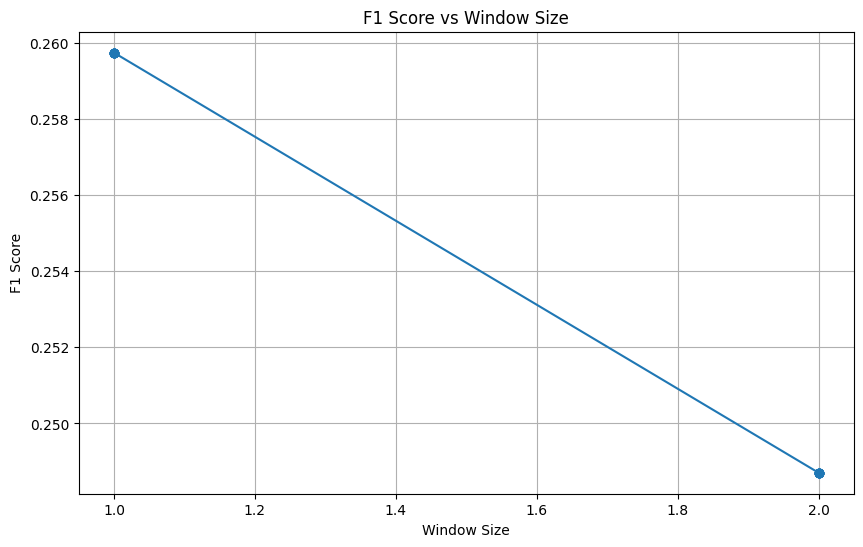

In [22]:
df_results['window_size'] = df_results['window_size'].astype(int)
df_results['f1_score'] = df_results['f1_score'].astype(float)

plt.figure(figsize=(10, 6))
plt.plot(df_results['window_size'], df_results['f1_score'], 'o-')
plt.xlabel('Window Size')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Window Size')
plt.grid(True)
plt.show()

# Multivariable Linear Regression

quantify the impact of each parameter on the F1 score.

Interpretation of Regression Results:
- Coefficients: show how each parameter influences the F1 score.
- P-values: indicate whether the effect of each parameter is statistically significant (usually p < 0.05).
- R-squared: how well the parameters explain the variation in the F1 score.

In [27]:
import statsmodels.api as sm

X = df_results[['window_size', 'character_change_threshold', 'similarity_threshold', 'place_memory_window_size']]
y = df_results['f1_score']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               f1_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.343e+26
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          2.93e-145
Time:                        11:05:59   Log-Likelihood:                 547.29
No. Observations:                  16   AIC:                            -1085.
Df Residuals:                      11   BIC:                            -1081.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


# Correlation Matrix
Shows how each parameter correlates with the F1 score

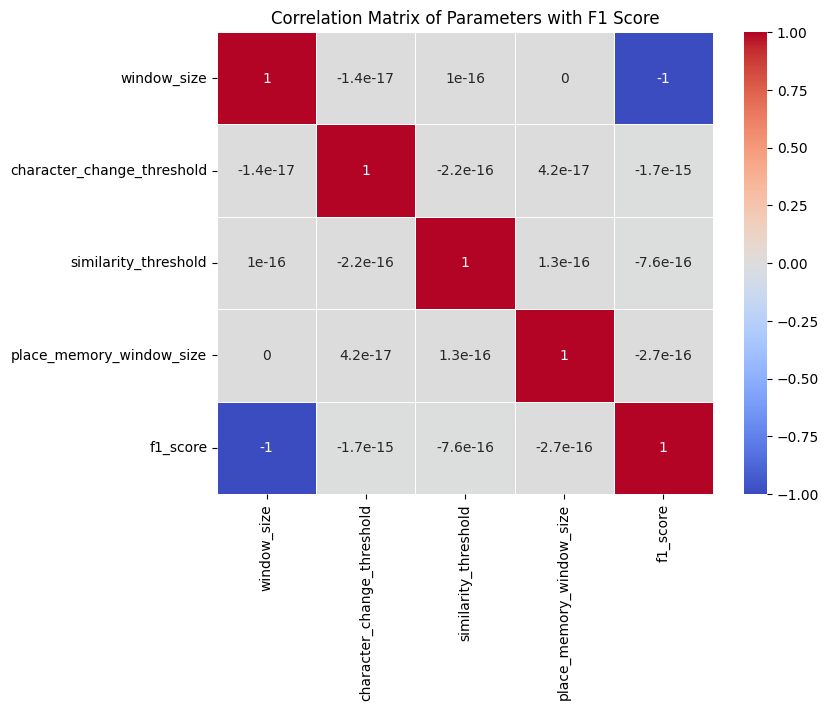

In [28]:
correlation_matrix = df_results[['window_size', 'character_change_threshold', 'similarity_threshold', 'place_memory_window_size', 'f1_score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Parameters with F1 Score')
plt.show()
